In [302]:
# Author: Daan van Stigt

# An MLP learning the XOR function

Illustrating the difference in learning ability between a simple single layer perceptron and a multilayer perceptron on the XOR function.

In [305]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

% matplotlib inline

# Use the plot style from seaborn
sns.set()

## Generate some XOR data

The **exclusive or** function, or [XOR](https://en.wikipedia.org/wiki/Exclusive_or) is defined as follows. Let $a,b \in \{0,1\}$. Then

$$XOR(a,b) = a + b\mod 2.$$

In [303]:
def xor(a,b):
    """
    xor(a,b) = a + b mod 2
    """
    return (a + b) % 2

def generate_xor_data():
    """
    Generates xor data.
    """
    xs = np.array([[a,b] for a in [0.,1.] for b in [0.,1.]]).T
    ys = xor(*xs)
    return xs, ys

In [304]:
# Generate the XOR data
xs, ys = generate_xor_data()
print(xs)
print(ys)

[[ 0.  0.  1.  1.]
 [ 0.  1.  0.  1.]]
[ 0.  1.  1.  0.]


The XOR function is not **linearly separable**. That is, there is no straight line to can that separate the zeros from the ones in (white and black) in the plot below:

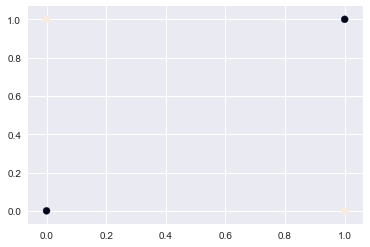

In [263]:
# Plot the XOR data
plt.scatter(xs[0], xs[1], c=list(ys))
plt.show()

## Perceptron

To illustrate this we train a simple [Perceptron](https://en.wikipedia.org/wiki/Perceptron) on the XOR data. The perceptron is a linear classifier, so it will not be able to get 100% accuracy on the XOR function (but we will make it try very hard nonetheless, poor perceptron).

In [127]:
import torch.nn as nn
from torch.autograd import Variable

class Perceptron(nn.Module):
    """
    A single layer perceptron that performs 
    logistic regression for binary classification.
    """
    def __init__(self):
        super(Perceptron, self).__init__()
        # One linear layer Wx + b, input dim 2 output dim 1
        self.i2o = nn.Linear(2,1) 
        # One nonlinearity at the output layer
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        output = self.sigmoid(self.i2o(input)) # sigmoid(Wx + b)
        return output

In [255]:
def train_step(model, input, true_labels, loss_criterion, learning_rate):
    """
    Performs a training step for the model.
    :param model: an instance of the class Perceptron or the class MLP
    :param loss_criterion: a PyTorch loss function (e.g. nn.MSELoss())
    :param learning_rate: a float value that is the learning_rate
    :returns: the output and the loss
    """
    # Set gradients to zero
    model.zero_grad()
    
    # Forward pass (compute output)
    output = model(input)
    
    # Compute the loss
    loss = loss_criterion(output, true_labels)

    # Backward pass (update gradients)
    # 1. Compute gradients wrt the loss
    loss.backward()
    # 2. Update gradients with gradients
    for k, p in enumerate(model.parameters()):
        p.data.add_(-learning_rate, p.grad.data)
    
    # Round output to nearest integer to get the
    # prediction
    predictions = np.around(output.data.numpy())
    # Get the loss as float number
    loss = float(np.squeeze(loss.data.numpy()))
    
    return predictions, loss

In [278]:
def classify_points(model, n):
    """
    Classifies the points in the [0,1]^2 using model.
    """
    result = np.zeros((n,n))
    for i in range(0, n):
        for j in range(n):
            inpt = Variable(torch.FloatTensor(np.array([[j/n, i/n]],
                                                       dtype=float)))
            prediction = model(inpt)
            result[i][j] = prediction.data.numpy()
    return result

def train(n, xs, ys, model, loss_criterion, learning_rate, print_every=10):
    """
    Trains the model (instance of Perceptron or MLP) on the data for n interations.
    """
    # For our reference
    print("Training with model {}".format(type(model)))
    
    for step in range(1,n+1):
        # Perform one training step
        predictions, loss = train_step(model, xs, ys, loss_criterion, learning_rate)
        # Plot predictions every 100 steps
        if step%print_every==0:
            # Get the accuracy of our predictions
            accuracy = 100 * float(np.mean(ys.data.numpy()==np.squeeze(predictions)))
            # Print the accuracy and the loss
            print('step {0} loss {1:.4f} accuracy {2:.2f}%'.format(step, loss, accuracy))
            
            # Let the model classify the points in the box [0,1]^2
            classified = classify_points(model, 100)
            
            # Plot the soft decision boundaries (values in the interval [0,1])
            sns.heatmap(classified, xticklabels=False, yticklabels=False, vmin=0, vmax=1)
            plt.title("soft decision boundary")
            plt.show()
            
            # Plot the prediction (hard decision boundary: value 0 or 1)
            sns.heatmap(np.around(classified), xticklabels=False, yticklabels=False, vmin=0, vmax=1)
            plt.title("hard decision boundary")
            plt.show()

Training with <class '__main__.Perceptron'>
step 10 loss 0.2524 accuracy 75.00%


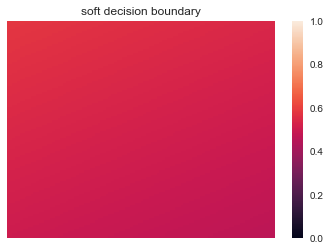

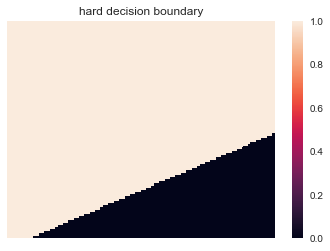

step 20 loss 0.2516 accuracy 50.00%


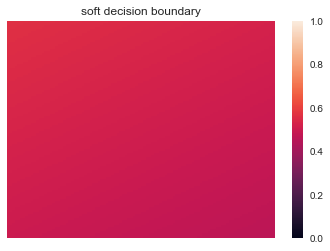

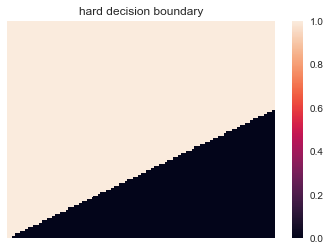

step 30 loss 0.2511 accuracy 75.00%


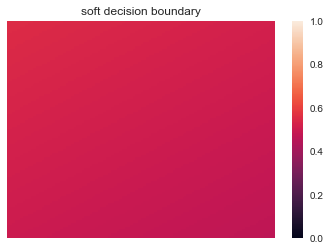

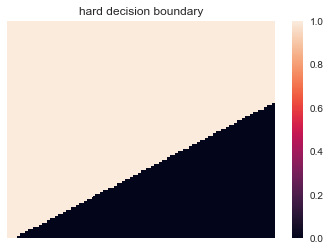

step 40 loss 0.2508 accuracy 75.00%


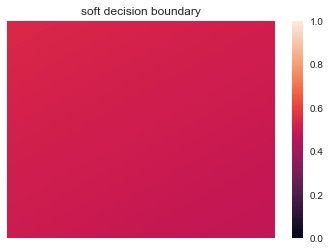

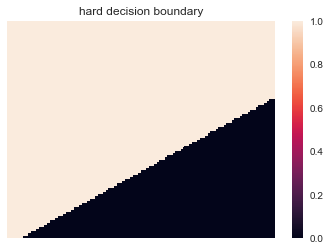

step 50 loss 0.2505 accuracy 75.00%


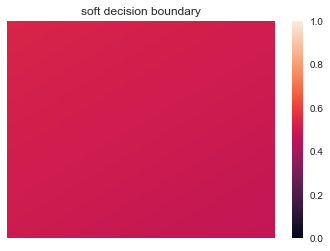

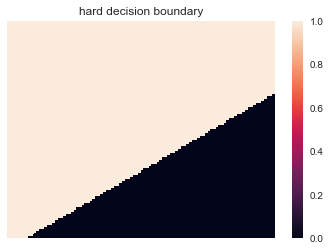

step 60 loss 0.2504 accuracy 75.00%


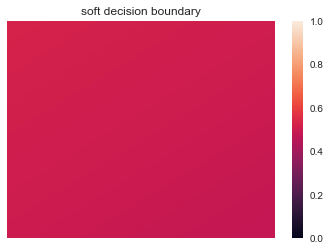

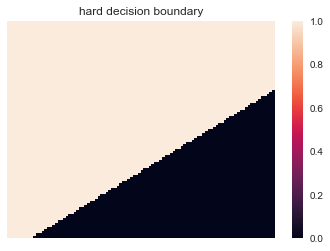

step 70 loss 0.2502 accuracy 75.00%


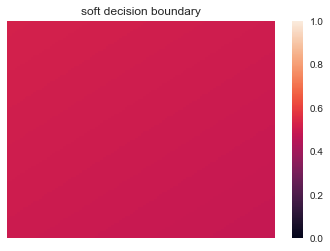

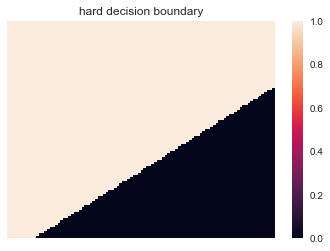

step 80 loss 0.2502 accuracy 75.00%


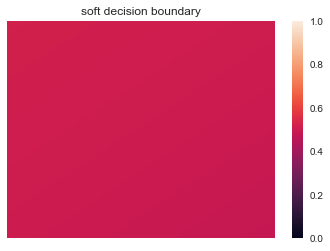

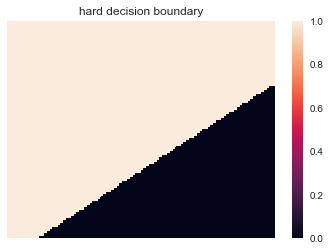

step 90 loss 0.2501 accuracy 75.00%


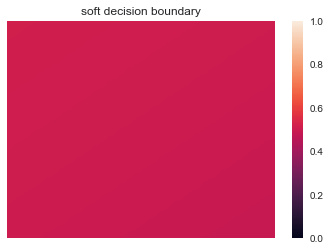

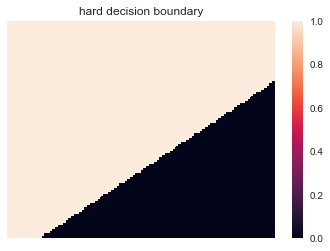

step 100 loss 0.2501 accuracy 75.00%


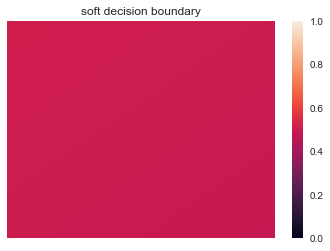

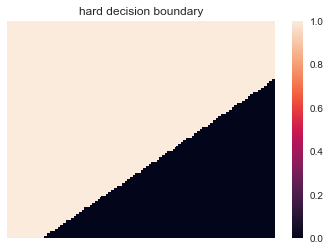

In [279]:
# Create a percetron
perceptron = Perceptron()

# Turn our data into a Variable to be input for PyTorch
xs_var = Variable(torch.FloatTensor(xs.T))
ys_var = Variable(torch.FloatTensor(ys))

# Use mean squared error (MSE) loss
loss_criterion = nn.MSELoss()
learning_rate = 1

train(100, xs_var, ys_var, perceptron, loss_criterion, learning_rate)

## MLP

A multilayer perceptron is the simplest example of a feedforward artificial neural network. The hidden layers together with the nonlinear activation functions (tanh, sigmoid, ReLU, etc.) give it the power to correctly classify data that is not linearly separable.

Let's illustrate that.

In [311]:
class MLP(nn.Module):
    """
    A multilayer perceptron that performs 
    logistic regression for binary classification.
    """
    def __init__(self, hidden_size):
        super(MLP, self).__init__()
        # First linear layer Wx + b with 
        # input dim 2 and output dim hidden_size
        self.i2h = nn.Linear(2,hidden_size)
        # Second linear layer Wx + b with 
        # input dim hidden_size and output dim 1
        self.h2o = nn.Linear(hidden_size,1)
        # The nonlinear function for the hidden layer
        self.tanh = nn.Tanh()
        # The output nonlinearity
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        hidden = self.tanh(self.i2h(input))
        output = self.sigmoid(self.h2o(hidden))
        return output

Training with <class '__main__.MLP'>
step 1000 loss 0.2501 accuracy 50.00%


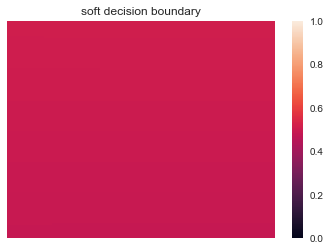

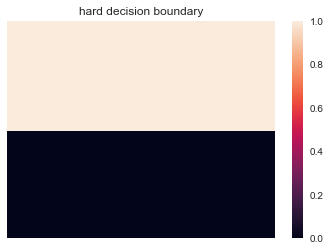

step 2000 loss 0.2499 accuracy 50.00%


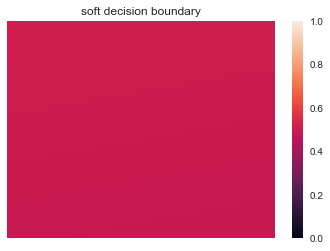

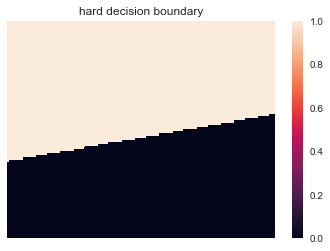

step 3000 loss 0.2495 accuracy 50.00%


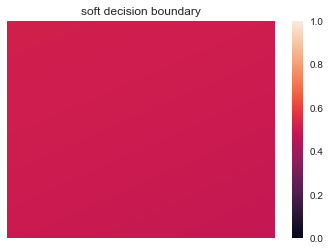

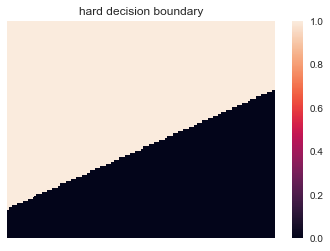

step 4000 loss 0.2470 accuracy 75.00%


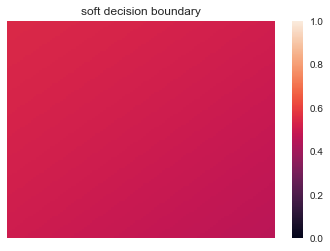

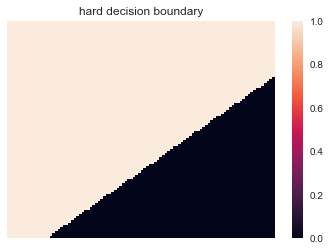

step 5000 loss 0.2198 accuracy 75.00%


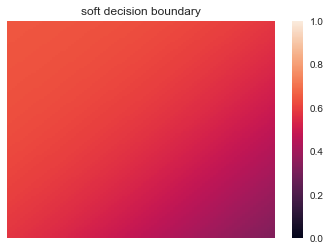

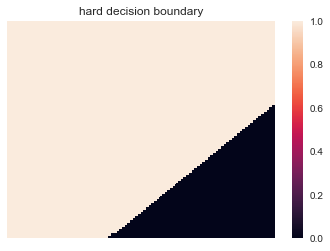

step 6000 loss 0.1863 accuracy 75.00%


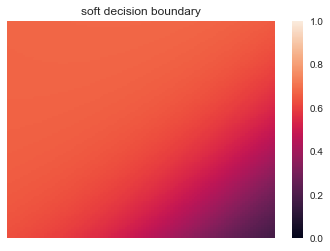

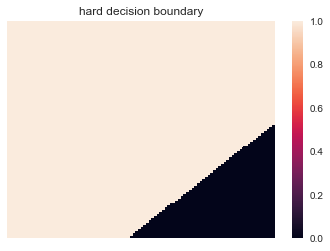

step 7000 loss 0.0283 accuracy 100.00%


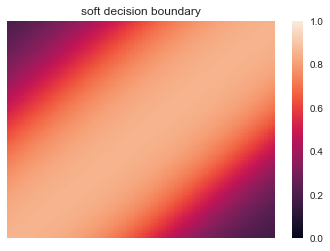

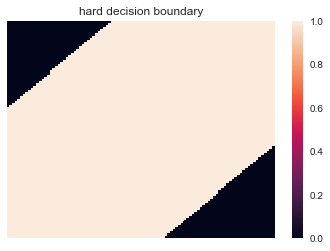

step 8000 loss 0.0085 accuracy 100.00%


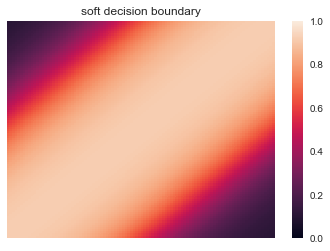

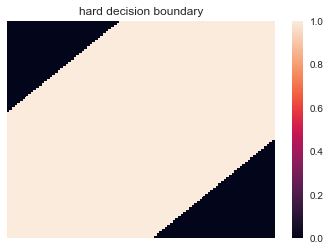

step 9000 loss 0.0047 accuracy 100.00%


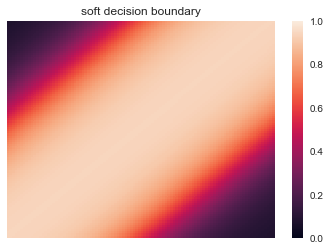

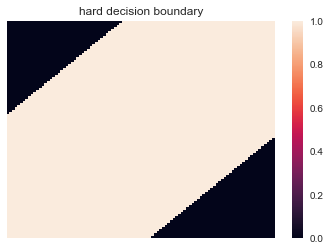

step 10000 loss 0.0032 accuracy 100.00%


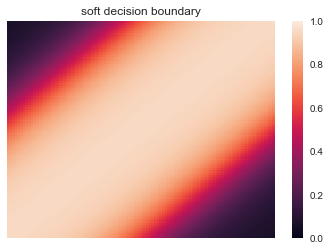

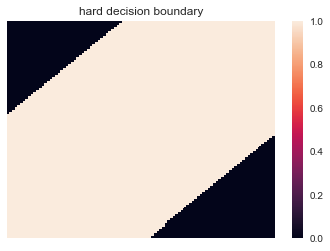

In [321]:
# Create a MLP with hidden dimension 2
mlp = MLP(2)

# MSE loss
loss_criterion = nn.MSELoss()
learning_rate = 0.1

train(10000, xs_var, ys_var, mlp, loss_criterion, learning_rate, print_every=1000)

We can inspect the learned transformations by accessing the weights and biases of the linear layers that we defined in our MLP:

In [336]:
W1 = mlp.i2h.weight
b1 = mlp.i2h.bias
print(W1)
print(b1)

Parameter containing:
 2.5395  2.5276
-2.7146 -2.7011
[torch.FloatTensor of size 2x2]

Parameter containing:
-1.1560
 4.0032
[torch.FloatTensor of size 2]



Compare these to the random weights of a freshly initialized MLP:

In [340]:
fresh_mlp = MLP(2)

fresh_W1 = fresh_mlp.i2h.weight
fresh_b1 = fresh_mlp.i2h.bias
print(fresh_W1)
print(fresh_b1)

Parameter containing:
 0.3396 -0.6156
-0.1647  0.6036
[torch.FloatTensor of size 2x2]

Parameter containing:
 0.3180
-0.5993
[torch.FloatTensor of size 2]



Making the hidden dimension larger gives the neural network more flexibility. And you can see that it will use this flexibility to learn a more non-linear decision boundary:

Training with <class '__main__.MLP'>
step 100 loss 0.2466 accuracy 75.00%


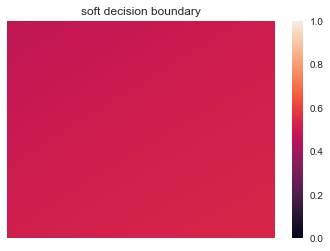

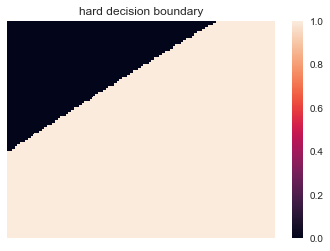

step 200 loss 0.2412 accuracy 75.00%


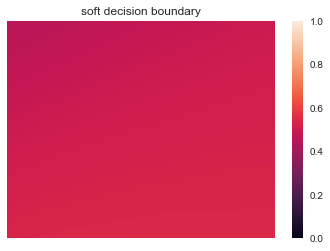

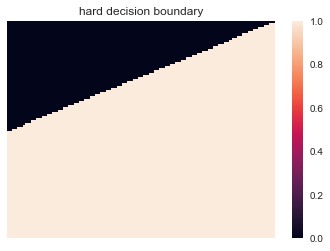

step 300 loss 0.2338 accuracy 50.00%


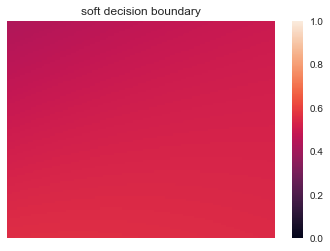

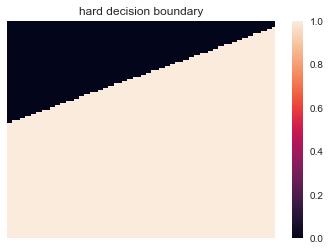

step 400 loss 0.2234 accuracy 50.00%


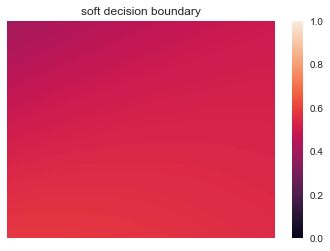

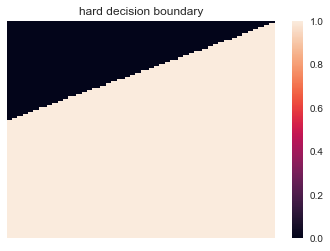

step 500 loss 0.2097 accuracy 75.00%


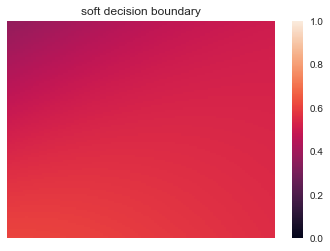

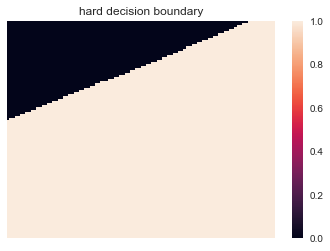

step 600 loss 0.1934 accuracy 75.00%


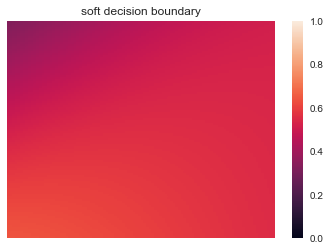

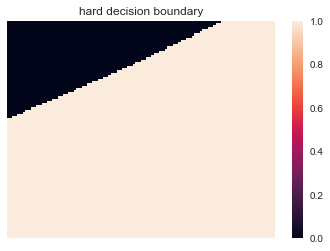

step 700 loss 0.1754 accuracy 75.00%


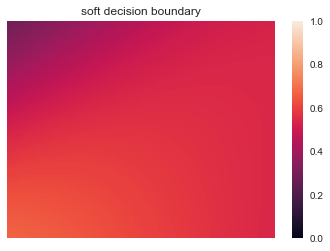

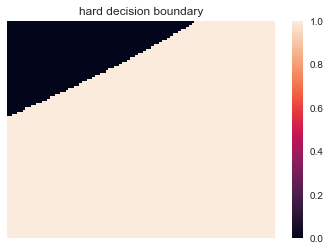

step 800 loss 0.1554 accuracy 75.00%


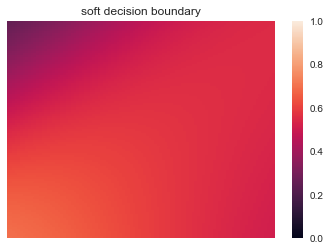

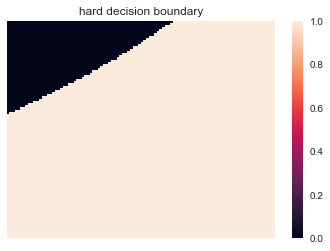

step 900 loss 0.1325 accuracy 100.00%


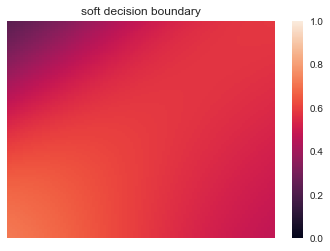

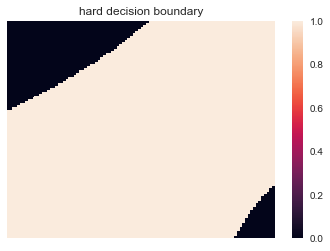

step 1000 loss 0.1077 accuracy 100.00%


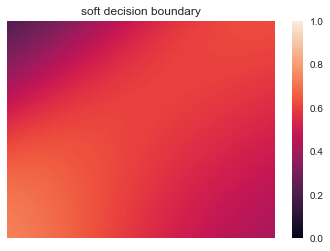

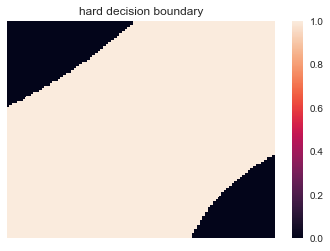

In [300]:
# Create a MLP with hidden dimension 50
mlp = MLP(10)

# MSE loss
loss_criterion = nn.MSELoss()
learning_rate = 0.1

train(1000, xs_var, ys_var, mlp, loss_criterion, learning_rate, print_every=100)

Training with <class '__main__.MLP'>
step 100 loss 0.2203 accuracy 100.00%


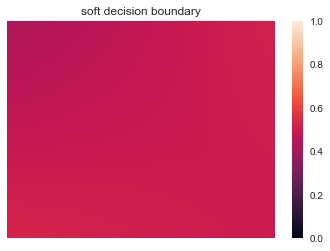

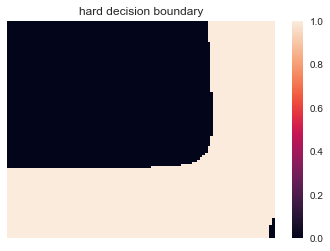

step 200 loss 0.1887 accuracy 100.00%


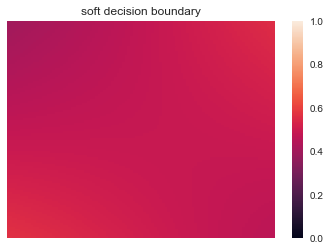

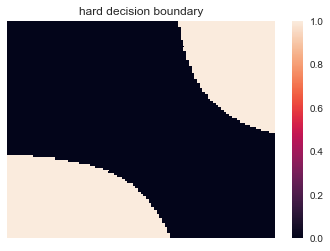

step 300 loss 0.1501 accuracy 100.00%


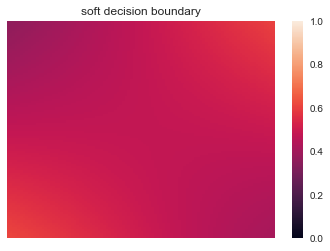

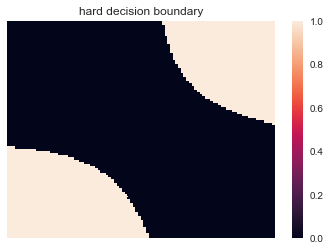

step 400 loss 0.1094 accuracy 100.00%


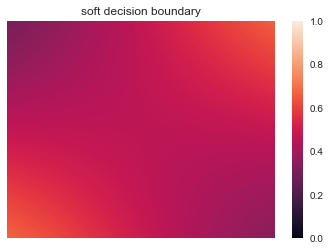

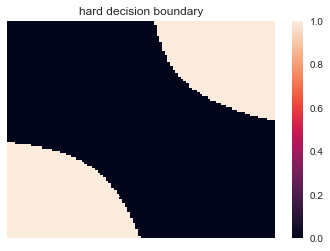

step 500 loss 0.0748 accuracy 100.00%


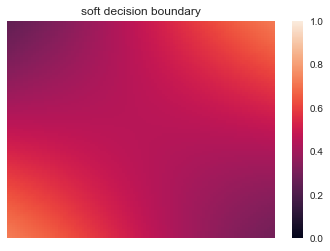

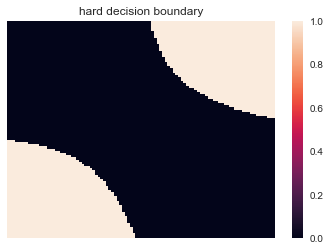

step 600 loss 0.0504 accuracy 100.00%


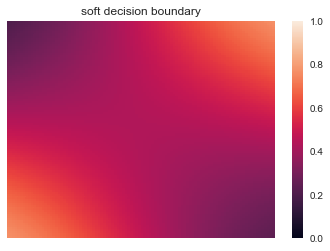

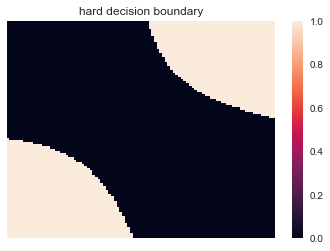

step 700 loss 0.0349 accuracy 100.00%


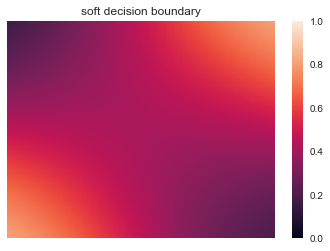

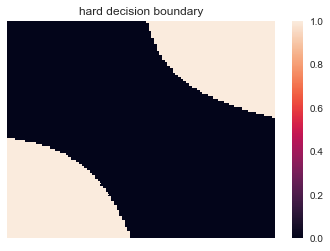

step 800 loss 0.0251 accuracy 100.00%


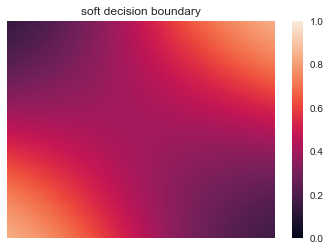

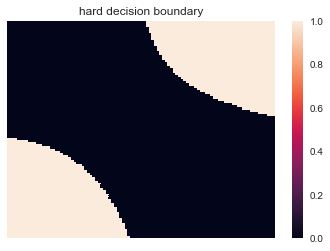

step 900 loss 0.0188 accuracy 100.00%


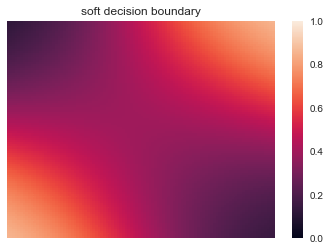

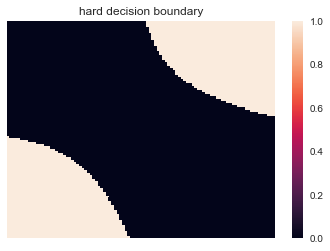

step 1000 loss 0.0147 accuracy 100.00%


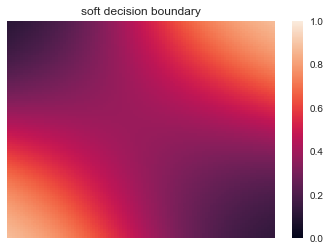

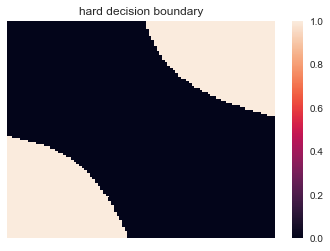

In [294]:
# Create a MLP with hidden dimension 100
mlp = MLP(100)

# MSE loss
loss_criterion = nn.MSELoss()
learning_rate = 0.1

train(1000, xs_var, ys_var, mlp, loss_criterion, learning_rate, print_every=100)

## Overfitting time!

Let's now try to go all-out for a complete overkill. We use a three-layered network with hidden layers of size 200. Let the overfitting begin!

In [289]:
import torch.nn as nn
from torch.autograd import Variable

class DeepMLP(nn.Module):
    """
    An MLP with three hidden layers.
    """
    def __init__(self, hidden_size):
        super(DeepMLP, self).__init__()
        
        self.i2h1 = nn.Linear(2,hidden_size)
        self.h12h2 = nn.Linear(hidden_size,hidden_size)
        self.h22h3 = nn.Linear(hidden_size,hidden_size)
        self.h2o = nn.Linear(hidden_size,1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    
    def forward(self, input):
        hidden1 = self.tanh(self.i2h1(input))
        hidden2 = self.tanh(self.h12h2(hidden1))
        hidden3 = self.tanh(self.h22h3(hidden2))
        output = self.sigmoid(self.h2o(hidden3))
        return output

Training with <class '__main__.DeepMLP'>
step 1000 loss 0.2156 accuracy 75.00%


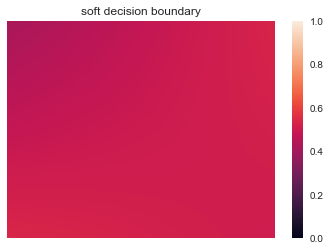

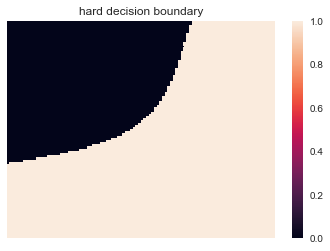

step 2000 loss 0.0480 accuracy 100.00%


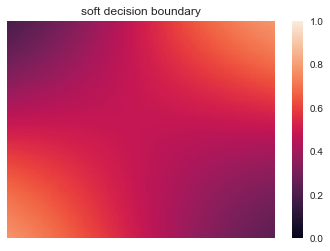

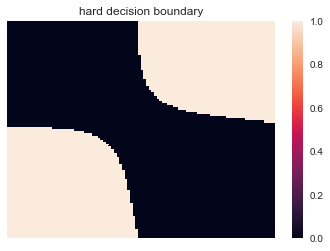

step 3000 loss 0.0063 accuracy 100.00%


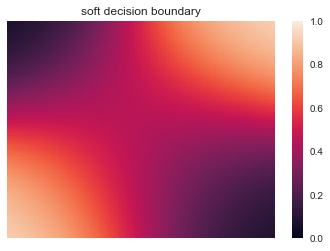

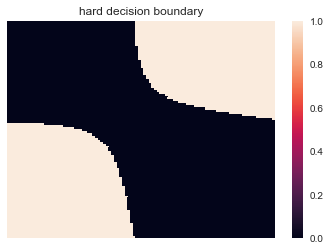

step 4000 loss 0.0025 accuracy 100.00%


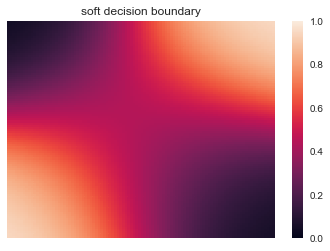

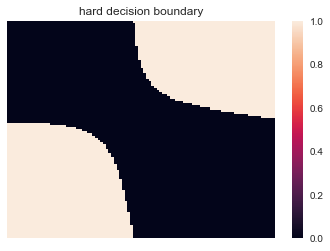

step 5000 loss 0.0015 accuracy 100.00%


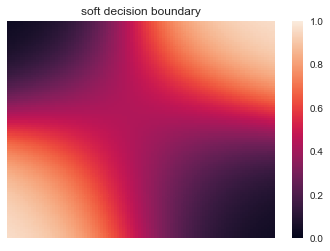

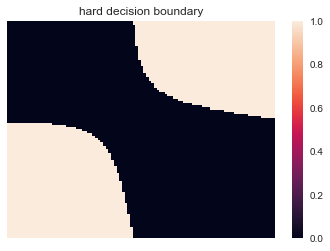

step 6000 loss 0.0010 accuracy 100.00%


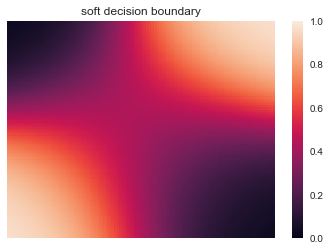

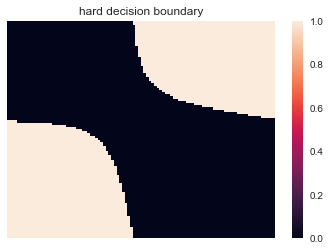

step 7000 loss 0.0007 accuracy 100.00%


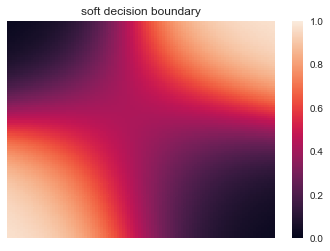

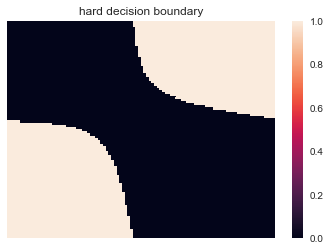

step 8000 loss 0.0006 accuracy 100.00%


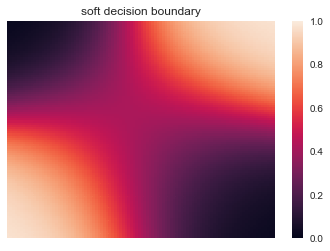

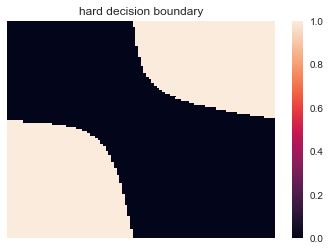

step 9000 loss 0.0005 accuracy 100.00%


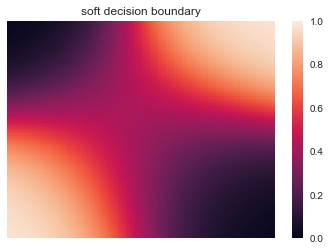

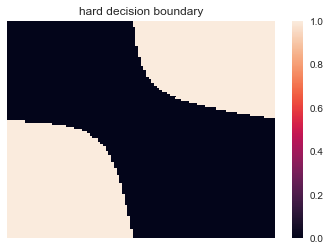

step 10000 loss 0.0004 accuracy 100.00%


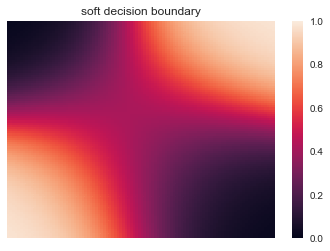

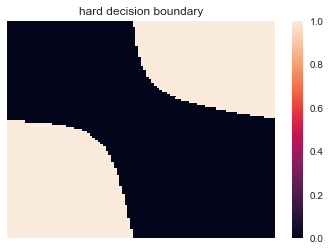

In [290]:
# Create a MLP with hidden dimension 2
deep_mlp = DeepMLP(200)

# MSE loss
loss_criterion = nn.MSELoss()
learning_rate = 0.01

train(10000, xs_var, ys_var, deep_mlp, loss_criterion, learning_rate, print_every=1000)